### 1. Importing Libraries and loading data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load Tweet dataset
df = pd.read_csv('/content/sample_data/Tweets.csv')
# Output first five rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0.0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0.0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df = df[df['airline_sentiment']=='negative'][['negativereason','text']]
df.reset_index(drop=True,inplace=True)
df.head(10)

,negativereason,text
0,Bad Flight,@VirginAmerica it's really aggressive to blast...
1,Can't Tell,@VirginAmerica and it's a really big bad thing...
2,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...
3,Late Flight,@VirginAmerica SFO-PDX schedule is still MIA.
4,Bad Flight,@VirginAmerica I flew from NYC to SFO last we...
5,Can't Tell,@VirginAmerica why are your first fares in May...
6,Customer Service Issue,@VirginAmerica you guys messed up my seating.....
7,Customer Service Issue,@VirginAmerica status match program. I applie...
8,Can't Tell,@VirginAmerica What happened 2 ur vegan food o...
9,Bad Flight,@VirginAmerica amazing to me that we can't get...


In [4]:
df['negativereason'].value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Flight Booking Problems         924
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Attendant Complaints     481
longlines                       178
Baggage Issue                   150
Damaged Luggage                  74
Name: count, dtype: int64

In [5]:
df.loc[df['negativereason'] == 'Late Flight', 'negativereason'] = 'Flight Cancellation and Delays'
df.loc[df['negativereason'] == 'Cancelled Flight', 'negativereason'] = 'Flight Cancellation and Delays'
df.loc[df['negativereason'] == 'longlines', 'negativereason'] = 'Bad Customer Experience'
df.loc[df['negativereason'] == 'Flight Attendant Complaints', 'negativereason'] = 'Bad Customer Experience'
df.loc[df['negativereason'] == 'Bad Flight', 'negativereason'] = 'Bad Customer Experience'
df.loc[df['negativereason'] == 'Damaged Luggage', 'negativereason'] = 'Baggage Issue'
df.loc[df['negativereason'] == 'Lost Luggage', 'negativereason'] = 'Baggage Issue'

In [6]:
df['negativereason'].value_counts()

negativereason
Customer Service Issue            2910
Flight Cancellation and Delays    2512
Bad Customer Experience           1239
Can't Tell                        1190
Baggage Issue                      948
Flight Booking Problems            924
Name: count, dtype: int64

In [7]:
df = df[(df['negativereason'] != 'longlines') & (df['negativereason'] != 'Customer Service Issue') & (df['negativereason'] != 'Damaged Luggage') & (df['negativereason'] != "Can't Tell")]

In [8]:
# Separate the DataFrame into three separate DataFrames based on category
df1 = df[df['negativereason'] == 'Flight Cancellation and Delays']
# df2 = df[df['negativereason'] == "Customer Service Issue"]
df3 = df[df['negativereason'] == "Flight Booking Problems"]
df4 = df[df['negativereason'] == "Bad Customer Experience"]
df5 = df[df['negativereason'] == "Baggage Issue"]



# Find the minimum count among all categories
# min_count = min(len(df1), len(df2), len(df3), len(df4), len(df5))
min_count = min(len(df1), len(df3), len(df4), len(df5))

# Sample from each category to match the minimum count
resampled_df1 = df1.sample(n=min_count, replace=True)
# resampled_df2 = df2.sample(n=min_count, replace=True)
resampled_df3 = df3.sample(n=min_count, replace=True)
resampled_df4 = df4.sample(n=min_count, replace=True)
resampled_df5 = df5.sample(n=min_count, replace=True)


# Concatenate the resampled DataFrames
# balanced_df = pd.concat([resampled_df1, resampled_df2, resampled_df3, resampled_df4, resampled_df5])
balanced_df = pd.concat([resampled_df1, resampled_df3, resampled_df4, resampled_df5])

# Shuffle the rows of the balanced DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)


balanced_df['negativereason'].value_counts()

df = balanced_df

In [9]:
df['negativereason'].value_counts()

negativereason
Flight Booking Problems           924
Baggage Issue                     924
Flight Cancellation and Delays    924
Bad Customer Experience           924
Name: count, dtype: int64

In [10]:
df.isnull().sum()

negativereason    0
text              0
dtype: int64

In [11]:
df['negativereason'].value_counts()

negativereason
Flight Booking Problems           924
Baggage Issue                     924
Flight Cancellation and Delays    924
Bad Customer Experience           924
Name: count, dtype: int64

### **EDA Analysis**

In [12]:
# The distribution of sentiments
df.groupby('negativereason').count().plot(kind='bar')

In [13]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

In [14]:
import plotly.express as px
fig = px.pie(df, names='negativereason', title ='Pie chart of different sentiments of tweets')
fig.show()

## **Data Preprocessing**

In [15]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [16]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

print("\nOriginal tweet ->", df['text'][0])
print("\nProcessed tweet ->", preprocess_text(df['text'][0]))


Original tweet -> @SouthwestAir me again! I was just trying to rebook fare on wanna get away pricing and it disappeared in time I refreshed. Is this normal?

Processed tweet ->  southwestair trying rebook fare wanna get away pricing disappeared time refreshed normal 


In [17]:
# Apply data processing to each tweet
X = list(map(preprocess_text, df['text']))
y = np.array(pd.get_dummies(df['negativereason']))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
np.array(X_train).shape,y_train.shape

((3141,), (3141, 4))

In [19]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [20]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

4309

In [21]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
# # Apply SMOTE only on the training data
# smote = SMOTE(random_state=42)
# X_train_re, y_train_re = smote.fit_resample(X_train, y_train)
# print(X_train_re.shape)
# print(y_train_re.shape)

In [25]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/sample_data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
embedding_matrix.shape

(4309, 100)

In [28]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## **Bidirectional LSTM Using NN**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout,SpatialDropout1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from keras import losses

epochs = 25
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9

sgd = SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(input_dim= vocab_length, output_dim= 100,input_shape= (maxlen,),embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [30]:
# import tensorflow as tf
# tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          430900    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                        

In [32]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7856
Precision : 0.8677
Recall    : 0.6973
F1 Score  : 0.7732


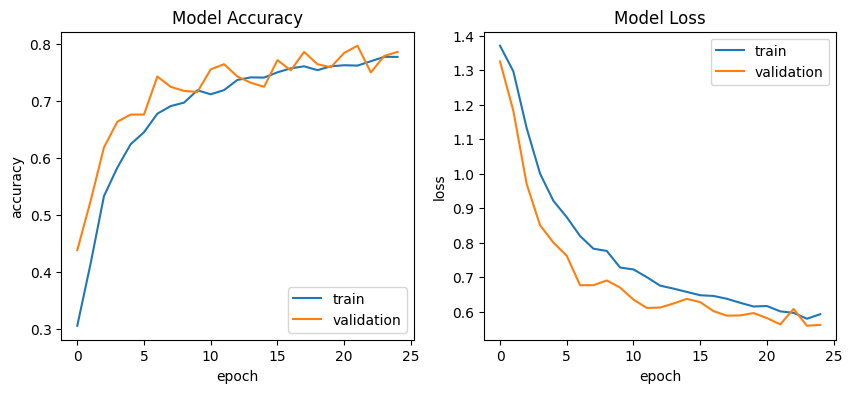

In [33]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

## **Model Confusion Matrix**

18/18 [==============================] - 1s 5ms/step


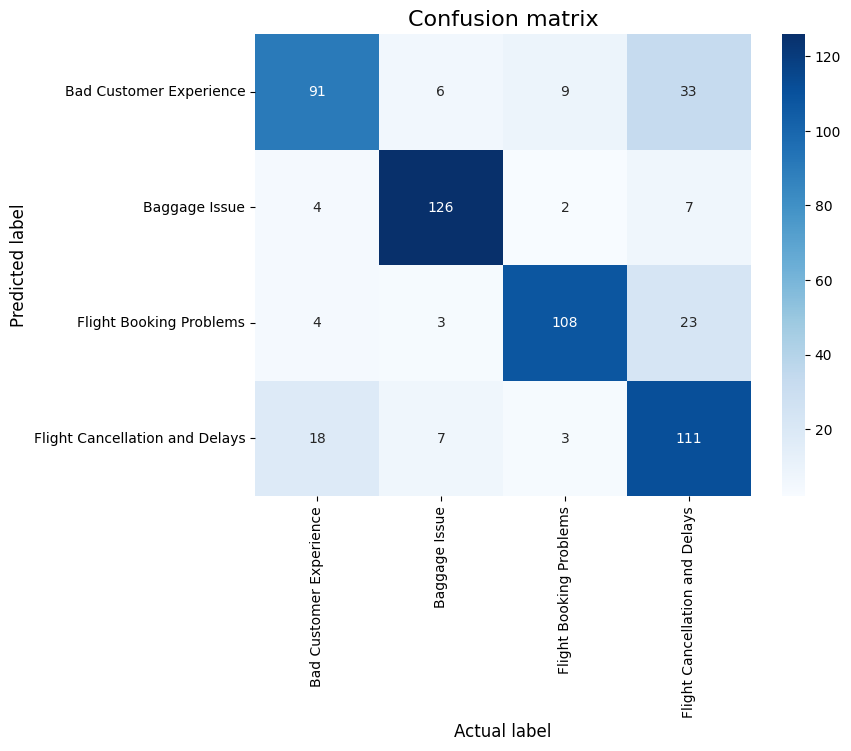

In [34]:
from sklearn.metrics import confusion_matrix,classification_report

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = list(np.unique(df['negativereason']))
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [35]:
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = list(np.unique(df['negativereason']))
    max_len=100

    text = preprocess_text(text)
    # Transforms text to a sequence of integers using a tokenizer object
    xt = word_tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    print(yt)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [36]:
predict_class('@united I attempted to book a ticket 3 times and kept getting a error message. I hope you didnt still charge me.')

3/3 [==============================] - 0s 46ms/step
[1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 1 1 1 3 3 1 1 1 1 1 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 1 3 3 1 3 1 1 1]
The predicted sentiment is Baggage Issue


In [37]:
predict_class('Flight turbulence was expected, but the lack of empathy from the flight crew was not. A simple reassurance would have made a huge difference. Disappointed')

4/4 [==============================] - 0s 30ms/step
[3 3 1 1 3 1 1 1 3 3 3 3 3 1 1 3 1 1 1 3 1 1 3 1 1 1 1 3 1 3 3 1 1 1 1 1 1
 3 1 1 3 3 1 1 3 1 1 3 3 1 3 1 1 1 1 1 3 1 1 3 1 1 1 1 3 3 1 1 3 1 1 3 1 3
 3 1 1 1 1 1 1 1 3 3 1 1 1 1 1 3 3 1 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
The predicted sentiment is Flight Cancellation and Delays


In [38]:
predict_class('@united united flight UA3774 after two delays just Cancelled Flightled no explanation &amp; no more flights to Norfolk that arent booked. Renting a car.')

4/4 [==============================] - 0s 30ms/step
[1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 1 1 3 1 1 3 1 1 1 3 1 1 1 1 3 1 1 1 1 3
 1 1 3 1 3 3 1 1 1 3 3 1 1 3 1 3 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 1 1 3 1 1 1 1 1 3 3 1 3 3 1 1 3 1 1 1 1 3 1 1 3 1 1 1 3 1 1 1 1 1 1 1 3 1
 3 1]
The predicted sentiment is Baggage Issue


In [39]:
predict_class('Just landed after a seriously delayed flight and no updates from the crew. Frustrating experience with no apologies or explanations. Expected better service.')

4/4 [==============================] - 0s 34ms/step
[3 1 1 1 1 1 1 1 1 3 1 1 3 1 3 1 1 1 1 3 1 1 1 1 1 3 3 1 1 3 1 1 3 1 1 1 1
 1 1 1 3 3 1 3 1 3 3 3 1 1 3 1 1 1 1 1 1 1 3 1 1 3 1 1 1 3 1 1 1 1 1 3 1 1
 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 3 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 3 1
 1 3 1 1]
The predicted sentiment is Flight Cancellation and Delays


In [40]:
z = """
@united Lost bags. Cancelled Flightled flights. Delhi call centers. Poor United staff spread thin and stressed. You name it.
"""

predict_class(z)

4/4 [==============================] - 0s 28ms/step
[1 3 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 1 3 1 1 3 1 3 3 1 1 1 3 3 1 1 3 1 3 1 1
 1 3 3 1 1 3 1 1 1 1 1 3 3 1 1 3 1 3 3 1 3 1 1 1 1 3 1 1 1 1 1 3 1 3 1 1 1
 1 1 1 1 1 1 3 3 1 1 1 3 1 1 1 1 1 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1]
The predicted sentiment is Baggage Issue
